# LAB 05 Assigment

Dominik Breksa (dominikbreksa@student.agh.edu.pl)

In [1]:
import numpy as np;import matplotlib.pyplot as plt;from open_atmos_jupyter_utils import show_plot;from functools import partial;plt.rcParams['axes.grid'] = True

In [2]:
def initial_conditions(x, x0, a, sigma):
    return a * np.exp(-(x - x0) ** 2 / 2 / sigma ** 2)

def solve_analytic(initial_condition, u, x, t):
    return initial_condition(x - u * t)

In [3]:
class Shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

In [4]:
def f(psi_l, psi_r, c):
    return .5 * (c + abs(c)) * psi_l + \
           .5 * (c - abs(c)) * psi_r

def upwind(psi, i, c):
    psi[i] = psi[i] - (
            f(psi[i], psi[i + one], c[i + hlf]) -
            f(psi[i - one], psi[i], c[i - hlf])
    )

def solve_upwind(*, nt: int, c: np.ndarray, psi: np.ndarray):
    assert np.all(np.abs(c) <= 1.), 'All C elements must be less than one'

    for _ in range(nt):
        upwind(psi, slice(1, len(c)), c)

    return psi

In [5]:
NT = 50
T_MAX = 150
DT = T_MAX / NT

In [6]:
NX = 50
X, DX = np.linspace(-100, 300, NX, retstep=True)

In [7]:
U = 1.25

In [8]:
INITIAL_CONDITIONS = partial(initial_conditions, x0=0., a=1., sigma=20.)
ANALYTIC_SOLUTION = partial(solve_analytic, INITIAL_CONDITIONS, U)

Here I present the


In [9]:
def corrective_c(c: np.ndarray, i: slice, psi: np.ndarray):
    denominator = psi[i] + psi[i - one]
    denominator = np.where(np.isclose(denominator, 0.), 0., (psi[i] - psi[i - one]) / denominator)
    return (np.abs(c[i - hlf]) - c[i - hlf] ** 2) * denominator

In [10]:
def solve_mpdata(*, nt: int, c: np.ndarray, psi: np.ndarray, iterations):
    assert np.all(np.abs(c) < 1.), 'All C elements must be less than one'
    i_ext = slice(1, len(psi))

    for _ in range(nt):
        upwind(psi, slice(1, len(c)), c)

        next_c = c.copy()
        for _ in range(iterations):
            next_c = corrective_c(next_c, i_ext, psi)
            assert np.all(np.abs(next_c) < 1.), 'All C elements must be less than one'

            upwind(psi, slice(1, len(next_c)), next_c)

    return psi

### Comparison of how the number of iterations changes the mpdata error with respect to an analytic solution

Root Mean Square Error is a measure of error between two vectors ($x^{pred}$ (the predicted vector) and $x^{true}$ (the actual vector)) of size $N$.

The function from above can be implemented as a Python function over vectors (copied and pasted from a previous lab):

In [19]:
def rmse(x_pred, x_true):
    assert x_pred.shape == x_true.shape, f'{x_pred.shape=} != {x_true.shape=}, The input vectors have different shapes'

    return np.sqrt(np.mean((x_pred - x_true) ** 2))

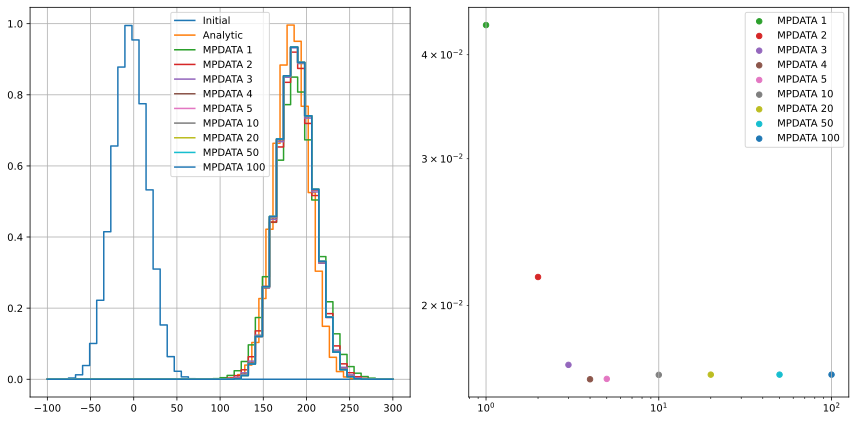

In [34]:
fig = plt.figure(figsize=(12, 6))
ax1, ax2 = fig.subplots(1, 2)

analytic_sol = ANALYTIC_SOLUTION(X, T_MAX)

ax1.step(X, INITIAL_CONDITIONS(X), label=f'Initial')
ax1.step(X, INITIAL_CONDITIONS(X), label=f'Upwind')
ax1.step(X, analytic_sol, label=f'Analytic')

for iterations in (1, 2, 3, 4, 5, 10, 20, 50, 100):
    mpdata_sol = solve_mpdata(nt=NT, c=np.full(NX - 1, U * DT / DX), psi=INITIAL_CONDITIONS(X), iterations=iterations)
    line, = ax1.step(X, mpdata_sol, label=f'MPDATA {iterations}', where='mid')
    ax2.scatter(iterations, rmse(mpdata_sol, analytic_sol), label=f'MPDATA {iterations}', color=line.get_color(), s=30)

ax1.set_title('')
ax1.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()

fig.tight_layout()

show_plot(fig=fig)

Results concluded from the plots:

- ...
- ...
- ...